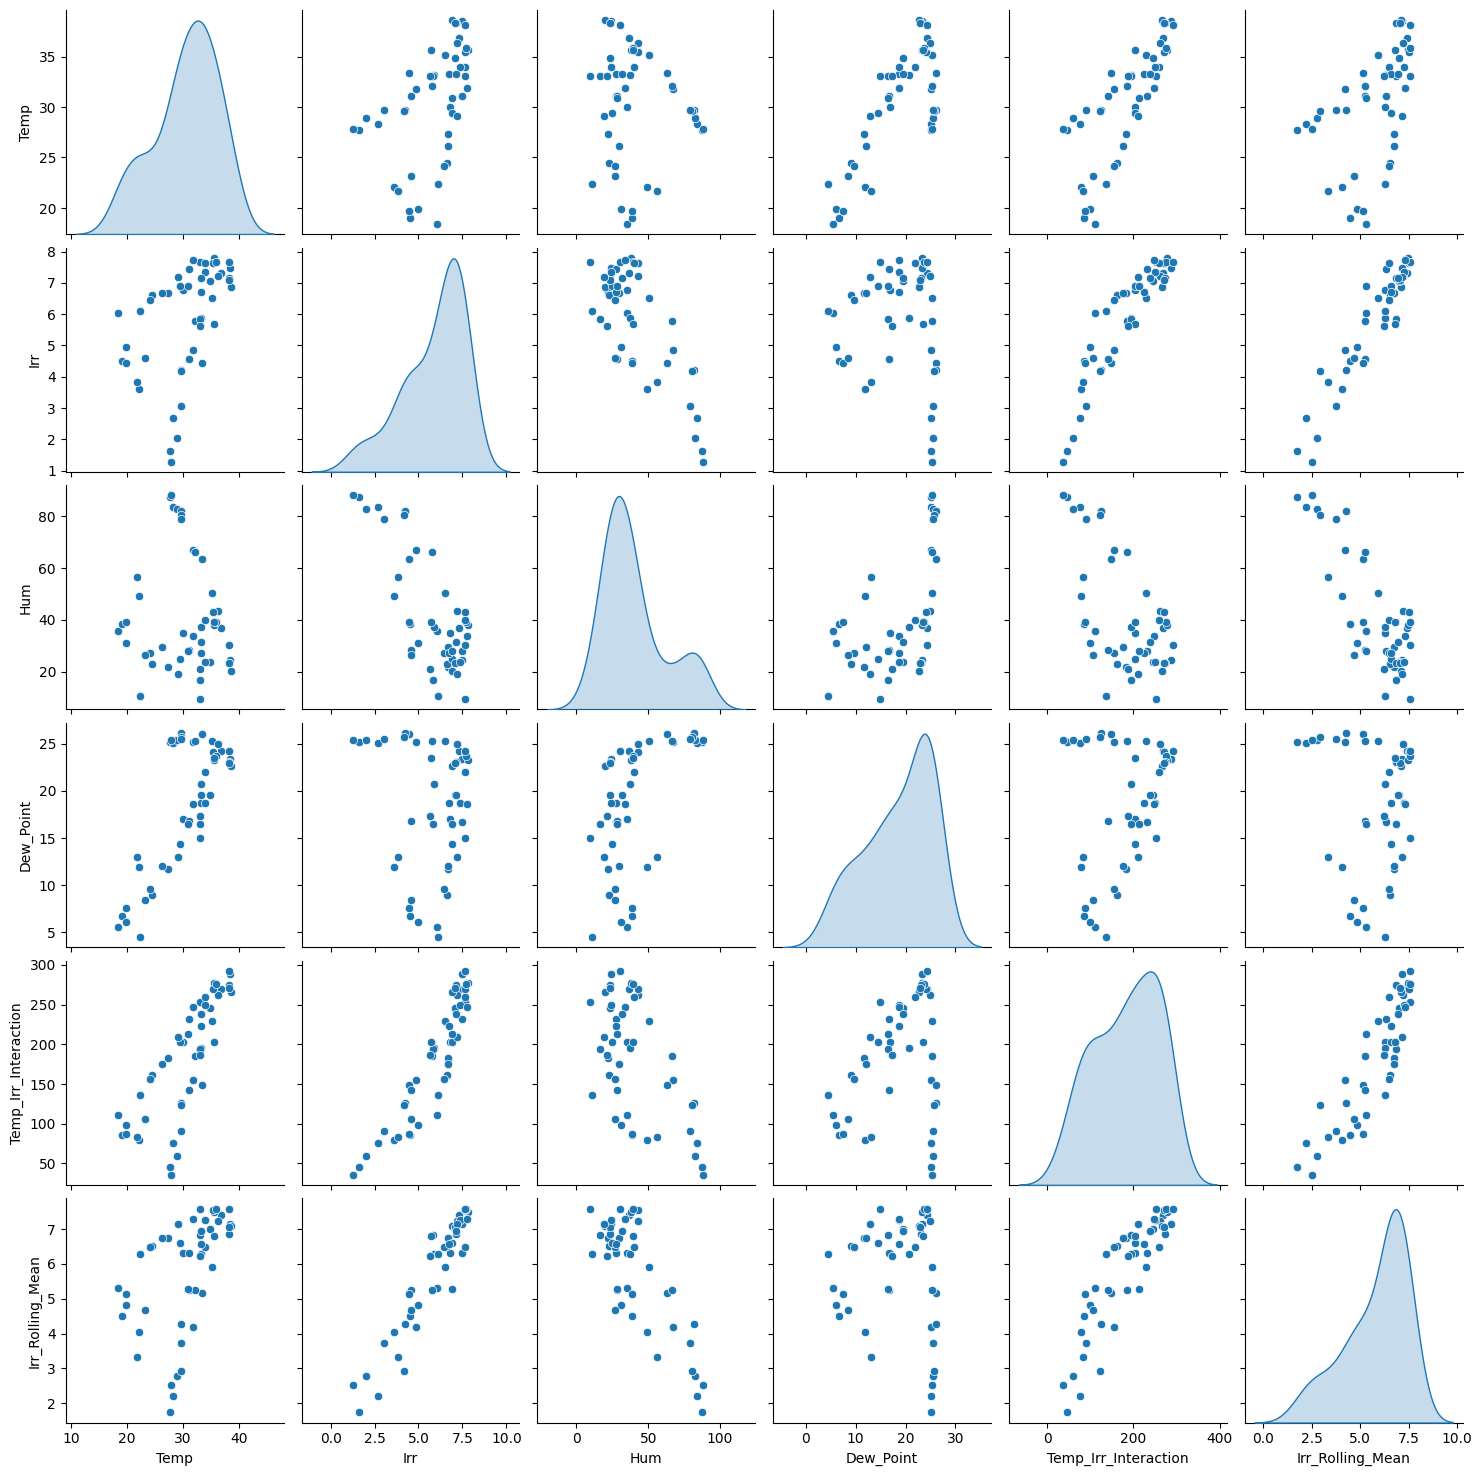

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('MP_HIL_SP - Sheet1.csv')

# Feature Engineering
df['Dew_Point'] = df['Temp'] - ((100 - df['Hum']) / 5)
df['Temp_Irr_Interaction'] = df['Temp'] * df['Irr']
df['Irr_Rolling_Mean'] = df['Irr'].rolling(window=3, min_periods=1).mean()

# Selecting key features for visualization
selected_features = ['Temp', 'Irr', 'Hum', 'Dew_Point', 'Temp_Irr_Interaction', 'Irr_Rolling_Mean']

# Pairplot for feature relationships
# Pairplot for Preprocessing Visualization with Reduced Data Points
sample_df = df.sample(n=50, random_state=42)  # Sample 500 data points for better visualization

sns.pairplot(sample_df[selected_features], diag_kind='kde')
plt.show()


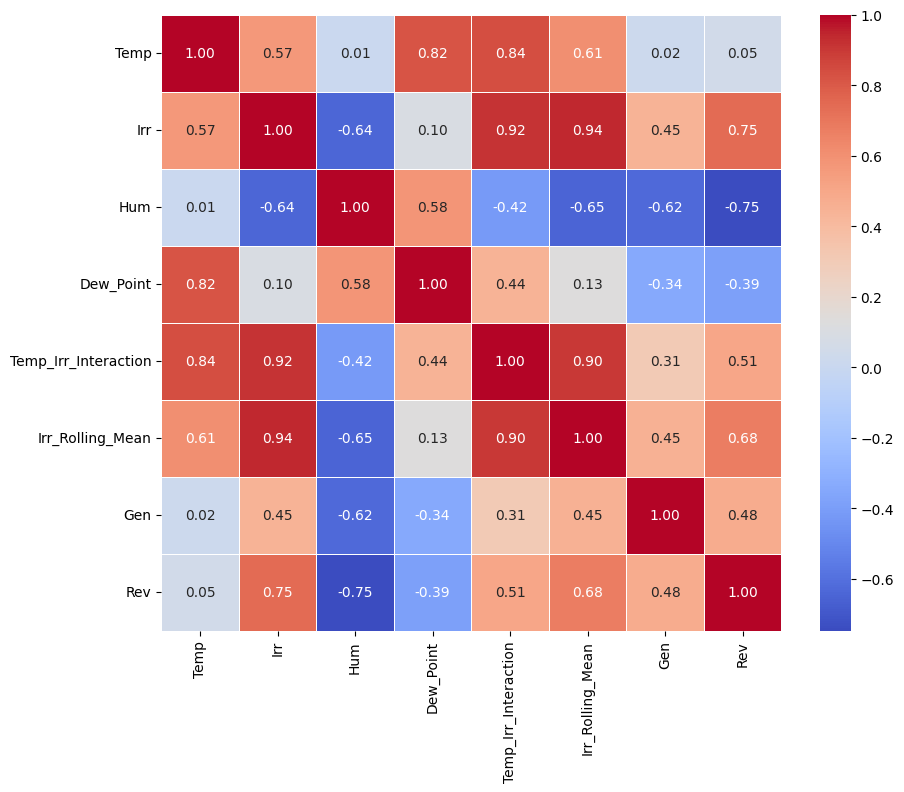

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Models saved successfully!

XGBoost Evaluation (Revenue):
MAE: 59.5046
RMSE: 140.1870
R² Score: 0.9990

XGBoost Evaluation (Generation):
MAE: 20.7147
RMSE: 50.2431
R² Score: 0.9978


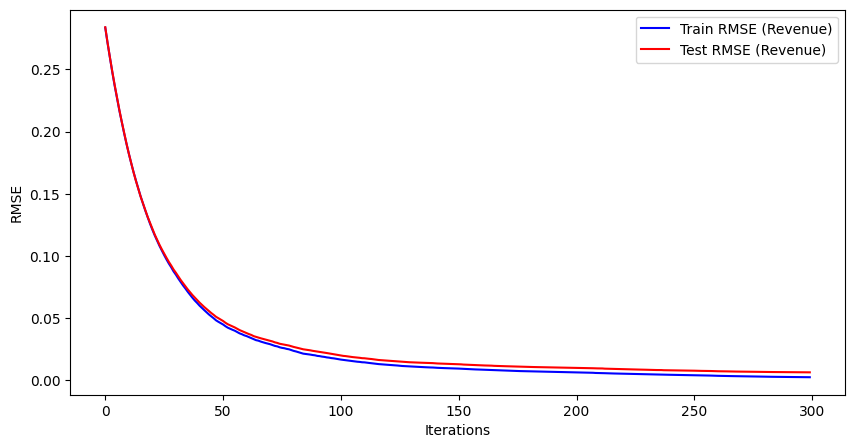

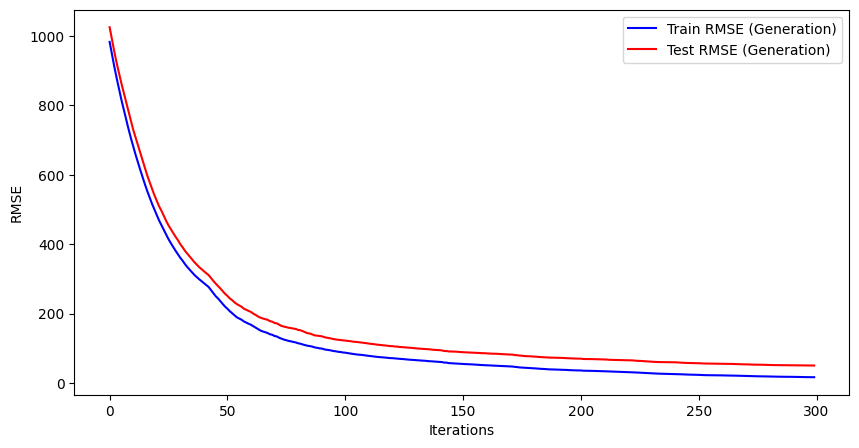

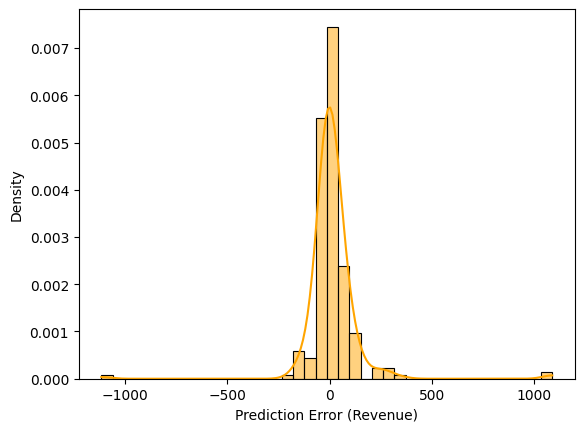

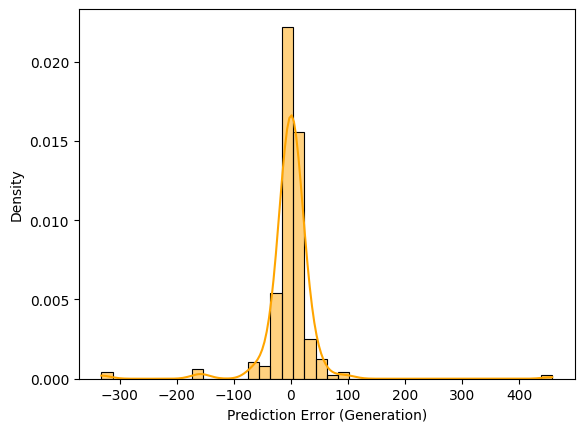

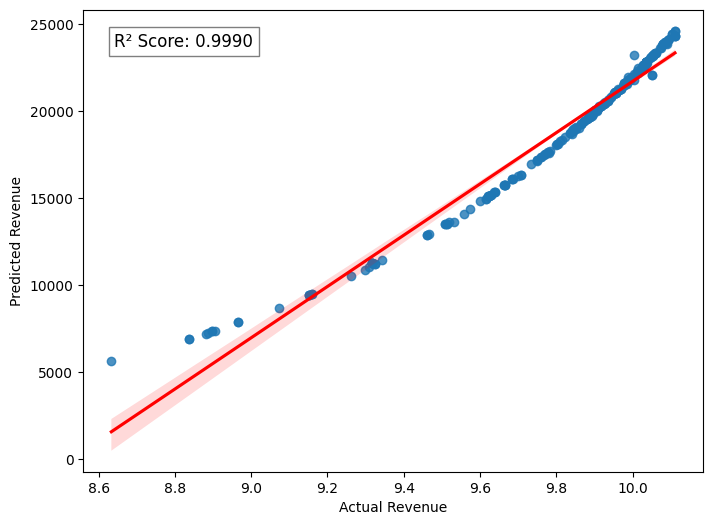

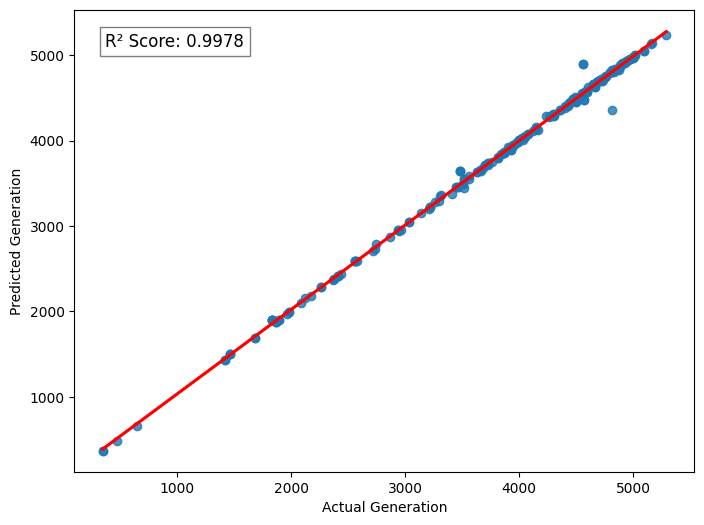

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import IsolationForest
from xgboost import XGBRegressor
from sklearn.utils import resample

# Load dataset
df = pd.read_csv('MP_HIL_SP - Sheet1.csv')

# Feature Engineering
df['Dew_Point'] = df['Temp'] - ((100 - df['Hum']) / 5)
df['Temp_Irr_Interaction'] = df['Temp'] * df['Irr']
df['Irr_Rolling_Mean'] = df['Irr'].rolling(window=3, min_periods=1).mean()

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['Temp', 'Irr', 'Hum']])
poly_columns = [f'poly_{i}' for i in range(poly_features.shape[1])]
df[poly_columns] = poly_features

# Outlier Removal using Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_labels = iso_forest.fit_predict(df[['Temp', 'Irr', 'Hum', 'Rev', 'Gen']])
df = df[outlier_labels == 1]

# Data Augmentation
synthetic_data = resample(df, replace=True, n_samples=1000, random_state=42)
df = pd.concat([df, synthetic_data])

# Compute the correlation matrix
selected_features = ['Temp', 'Irr', 'Hum', 'Dew_Point', 'Temp_Irr_Interaction', 'Irr_Rolling_Mean', 'Gen', 'Rev']
corr_matrix = df[selected_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

# Log transformation for revenue
df['Log_Rev'] = np.log1p(df['Rev'])

# Train-test split
X = df[['Temp', 'Irr', 'Hum', 'Dew_Point', 'Temp_Irr_Interaction', 'Irr_Rolling_Mean'] + poly_columns]
y = df[['Log_Rev', 'Gen']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
xgb_rev_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6)
xgb_gen_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6)

xgb_rev_model.fit(X_train, y_train['Log_Rev'].values.ravel(), eval_set=[(X_train, y_train['Log_Rev']), (X_test, y_test['Log_Rev'])], eval_metric='rmse', verbose=False)
xgb_gen_model.fit(X_train, y_train['Gen'].values.ravel(), eval_set=[(X_train, y_train['Gen']), (X_test, y_test['Gen'])], eval_metric='rmse', verbose=False)

# Save Models
joblib.dump(xgb_rev_model, "solar_revenue_model.pkl")
joblib.dump(xgb_gen_model, "solar_generation_model.pkl")
print("Models saved successfully!")

# Predictions
y_pred_rev = xgb_rev_model.predict(X_test)
y_pred_rev = np.expm1(y_pred_rev)  # Reverse log transformation
y_test_exp = np.expm1(y_test['Log_Rev'])

y_pred_gen = xgb_gen_model.predict(X_test)

# Model Evaluation
print("\nXGBoost Evaluation (Revenue):")
print(f"MAE: {mean_absolute_error(y_test_exp, y_pred_rev):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_exp, y_pred_rev)):.4f}")
print(f"R² Score: {r2_score(y_test_exp, y_pred_rev):.4f}")

print("\nXGBoost Evaluation (Generation):")
print(f"MAE: {mean_absolute_error(y_test['Gen'], y_pred_gen):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test['Gen'], y_pred_gen)):.4f}")
print(f"R² Score: {r2_score(y_test['Gen'], y_pred_gen):.4f}")

# Training vs Testing Loss Graph
evals_result_rev = xgb_rev_model.evals_result()
evals_result_gen = xgb_gen_model.evals_result()

plt.figure(figsize=(10, 5))
plt.plot(evals_result_rev['validation_0']['rmse'], label='Train RMSE (Revenue)', color='blue')
plt.plot(evals_result_rev['validation_1']['rmse'], label='Test RMSE (Revenue)', color='red')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(evals_result_gen['validation_0']['rmse'], label='Train RMSE (Generation)', color='blue')
plt.plot(evals_result_gen['validation_1']['rmse'], label='Test RMSE (Generation)', color='red')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Prediction Error Distribution
errors = y_test_exp - y_pred_rev
sns.histplot(data=errors, kde=True, bins=40, stat='density', color='orange')
plt.xlabel('Prediction Error (Revenue)')
plt.ylabel('Density')
plt.show()

errors_gen = y_test['Gen'] - y_pred_gen
sns.histplot(data=errors_gen, kde=True, bins=40, stat='density', color='orange')
plt.xlabel('Prediction Error (Generation)')
plt.ylabel('Density')

plt.show()

# Prediction vs Actual Scatter Plots
y_test['Rev_Predict'] = y_pred_rev
y_test['Gen_Predict'] = y_pred_gen

plt.figure(figsize=(8, 6))
sns.regplot(data=y_test.sample(n=min(250, len(y_test))), x='Log_Rev', y='Rev_Predict', line_kws={"color": "red"})
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.text(0.05, 0.95, f'R² Score: {r2_score(y_test_exp, y_pred_rev):.4f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

plt.figure(figsize=(8, 6))
sns.regplot(data=y_test.sample(n=min(250, len(y_test))), x='Gen', y='Gen_Predict', line_kws={"color": "red"})
plt.xlabel('Actual Generation')
plt.ylabel('Predicted Generation')
plt.text(0.05, 0.95, f'R² Score: {r2_score(y_test["Gen"], y_pred_gen):.4f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1216 entries, 0 to 178
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temp                  1216 non-null   float64
 1   Irr                   1216 non-null   float64
 2   Hum                   1216 non-null   float64
 3   Gen                   1216 non-null   float64
 4   Rev                   1216 non-null   float64
 5   Dew_Point             1216 non-null   float64
 6   Temp_Irr_Interaction  1216 non-null   float64
 7   Irr_Rolling_Mean      1216 non-null   float64
 8   poly_0                1216 non-null   float64
 9   poly_1                1216 non-null   float64
 10  poly_2                1216 non-null   float64
 11  poly_3                1216 non-null   float64
 12  poly_4                1216 non-null   float64
 13  poly_5                1216 non-null   float64
 14  poly_6                1216 non-null   float64
 15  poly_7                1216 

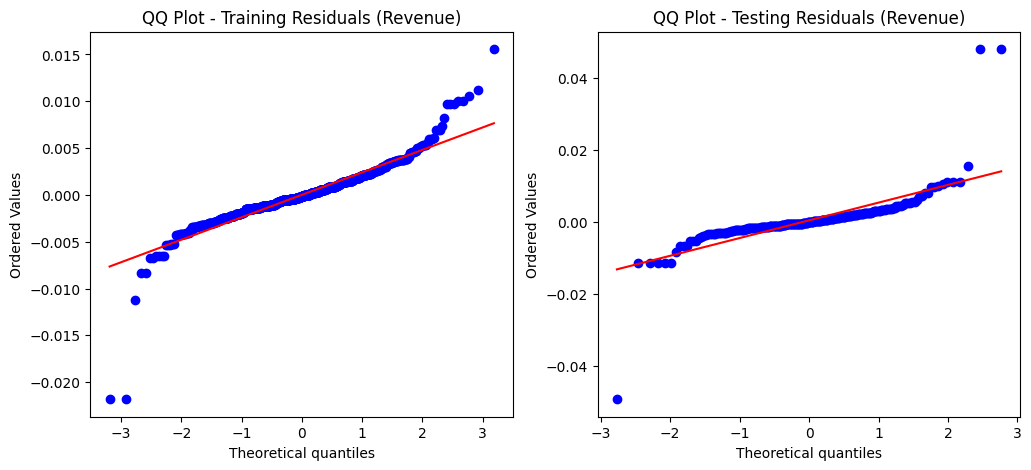

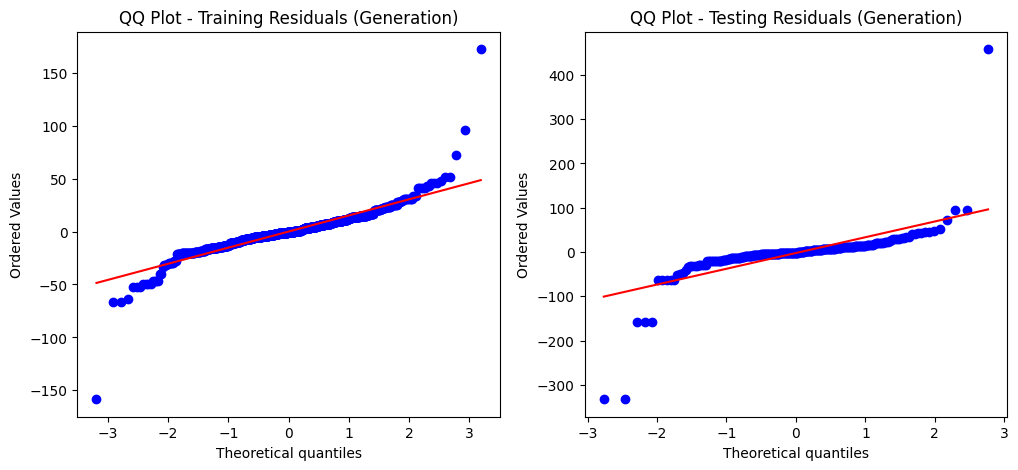

In [14]:
import scipy.stats as stats

# QQ Plot for Training and Testing Residuals - Revenue
train_residuals_rev = y_train['Log_Rev'] - xgb_rev_model.predict(X_train)
test_residuals_rev = y_test['Log_Rev'] - xgb_rev_model.predict(X_test)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(train_residuals_rev, dist="norm", plot=plt)
plt.title("QQ Plot - Training Residuals (Revenue)")

plt.subplot(1, 2, 2)
stats.probplot(test_residuals_rev, dist="norm", plot=plt)
plt.title("QQ Plot - Testing Residuals (Revenue)")

plt.show()

# QQ Plot for Training and Testing Residuals - Generation
train_residuals_gen = y_train['Gen'] - xgb_gen_model.predict(X_train)
test_residuals_gen = y_test['Gen'] - xgb_gen_model.predict(X_test)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(train_residuals_gen, dist="norm", plot=plt)
plt.title("QQ Plot - Training Residuals (Generation)")

plt.subplot(1, 2, 2)
stats.probplot(test_residuals_gen, dist="norm", plot=plt)
plt.title("QQ Plot - Testing Residuals (Generation)")

plt.show()



In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet, RidgeCV, LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import IsolationForest
from sklearn.utils import resample
#import skill_metrics as sm  # Taylor plot library

# Load dataset
df = pd.read_csv('MP_HIL_SP - Sheet1.csv')

# Feature Engineering
df['Dew_Point'] = df['Temp'] - ((100 - df['Hum']) / 5)
df['Temp_Irr_Interaction'] = df['Temp'] * df['Irr']
df['Irr_Rolling_Mean'] = df['Irr'].rolling(window=3, min_periods=1).mean()

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['Temp', 'Irr', 'Hum']])
poly_columns = [f'poly_{i}' for i in range(poly_features.shape[1])]
df[poly_columns] = poly_features

# Outlier Removal (Isolation Forest)
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_labels = iso_forest.fit_predict(df[['Temp', 'Irr', 'Hum', 'Rev', 'Gen']])
df = df[outlier_labels == 1]

# Data Augmentation
df = pd.concat([df, resample(df, replace=True, n_samples=1000, random_state=42)])

# Log transformation for revenue
df['Log_Rev'] = np.log1p(df['Rev'])

# Train-Test Split
X = df[['Temp', 'Irr', 'Hum', 'Dew_Point', 'Temp_Irr_Interaction', 'Irr_Rolling_Mean'] + poly_columns]
y = df[['Log_Rev', 'Gen']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models to Train
models = {
    'XGBoost': XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=300, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=6),
    'HistGradientBoosting': HistGradientBoostingRegressor(max_iter=300),
    'BayesianRidge': BayesianRidge(),
    'ElasticNet': ElasticNet(),
    'RidgeCV': RidgeCV(),
    'LassoCV': LassoCV(),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500),
    'GaussianProcess': GaussianProcessRegressor()
}

# Store results
r2_scores = {}
std_devs = []
rmse_vals = []
correlations = []

# Train and Evaluate Models
for name, model in models.items():
    model.fit(X_train, y_train['Log_Rev'])
    y_pred_rev = np.expm1(model.predict(X_test))
    y_test_exp = np.expm1(y_test['Log_Rev'])
    
    model.fit(X_train, y_train['Gen'])
    y_pred_gen = model.predict(X_test)
    
    # Compute Metrics
    r2_rev = r2_score(y_test_exp, y_pred_rev)
    r2_gen = r2_score(y_test['Gen'], y_pred_gen)
    
    r2_scores[name] = {'Revenue': r2_rev, 'Generation': r2_gen}
    
    # Taylor Plot Metrics
    std_devs.append(np.std(y_pred_gen))
    rmse_vals.append(np.sqrt(mean_squared_error(y_test['Gen'], y_pred_gen)))
    correlations.append(np.corrcoef(y_test['Gen'], y_pred_gen)[0, 1])
    
    print(f"{name} - Revenue R²: {r2_rev:.4f}, Generation R²: {r2_gen:.4f}")

# Taylor Plot
plt.figure(figsize=(8, 8))
sm.taylor_diagram(std_devs, rmse_vals, correlations, markerLabel=list(models.keys()), markerLegend='on')
plt.title("Taylor Plot for Model Performance")
plt.show()


XGBoost - Revenue R²: 0.9990, Generation R²: 0.9978
RandomForest - Revenue R²: 0.9943, Generation R²: 0.9891
ExtraTrees - Revenue R²: 0.9995, Generation R²: 0.9979
GradientBoosting - Revenue R²: 0.9993, Generation R²: 0.9991
HistGradientBoosting - Revenue R²: 0.9984, Generation R²: 0.9977
BayesianRidge - Revenue R²: 0.7845, Generation R²: 0.3710
ElasticNet - Revenue R²: 0.7387, Generation R²: 0.3799


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.747e+08, tolerance: 1.015e+05
  model = cd_fast.enet_coordinate_descent(


RidgeCV - Revenue R²: 0.7910, Generation R²: 0.3379
LassoCV - Revenue R²: 0.7398, Generation R²: 0.3693


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor - Revenue R²: -53.6876, Generation R²: 0.3841
GaussianProcess - Revenue R²: 0.6794, Generation R²: 0.7640


NameError: name 'sm' is not defined

<Figure size 800x800 with 0 Axes>